<a href="https://colab.research.google.com/github/E-xxi/kaggle_house-price/blob/data_observe/houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Prices - Advanced Regression Techniques**
sale prices를 예측하는 것이 주제이다.




우선 데이터의 형태를 관찰해보도록 한다. 

# 파일 다운로드 및 실행

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle
%pwd


Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

%mkdir input/house-price

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 20.8MB/s]
house-prices-advanced-regression-techniques.zip  kaggle.json
input						 lecture07_Project02_2020113677
mv: cannot stat 'house-prices-advanced-regression-techniques': No such file or directory


In [ ]:
%mv house-prices-advanced-regression-techniques.zip input/house-price
%cd input/house-price/

!unzip \*.zip  && rm *.zip

/content/gdrive/MyDrive/Kaggle/input/house-price
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# House Price 데이터 관찰하기

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Kaggle/input/house-price'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%pwd

/content/gdrive/My Drive/Kaggle/input/house-price/test.csv
/content/gdrive/My Drive/Kaggle/input/house-price/train.csv
/content/gdrive/My Drive/Kaggle/input/house-price/data_description.txt
/content/gdrive/My Drive/Kaggle/input/house-price/sample_submission.csv


'/content/gdrive/My Drive/Kaggle'

In [ ]:
%cd input/house-price/

data = pd.read_csv('train.csv')
#data.info()

/content/gdrive/My Drive/Kaggle/input/house-price


전체 칼럼을 확인해보면서 특정 유형이 90%이상의 비율을 차지하는 칼럼이 있는지 확인한다.

이것을 확인하는 이유는 반드시 필수적으로 필요한 부분이 무엇인지 그리고 굳이 고려할 필요가 없는 칼럼이 무엇이 있는지를 확인하기 위함이다.

- Dtype이 object 인 경우만 우선 고려하겠다.

값 전체에 대해 90프로를 차지하는 것을 확인한다.

In [ ]:
#DType이 object인 경우

overallMaj = pd.DataFrame()
for c in list(data.columns):
  if data[c].dtype != 'object':
    continue

  #특정요소가 라인의 90프로 이상을 차지한다면 출력
  for k in data[c].value_counts().values:
    if k >= data[c].count() * 0.9:
      new = {'title': c, 'val' : data[c].value_counts().keys()[0], 'cnt': k}
      overallMaj = overallMaj.append(new, ignore_index = True)

print(overallMaj)


          title      val     cnt
0        Street     Pave  1454.0
1     Utilities   AllPub  1459.0
2     LandSlope      Gtl  1382.0
3    Condition2     Norm  1445.0
4      RoofMatl  CompShg  1434.0
5      BsmtCond       TA  1311.0
6       Heating     GasA  1428.0
7    CentralAir        Y  1365.0
8    Electrical    SBrkr  1334.0
9    Functional      Typ  1360.0
10   GarageQual       TA  1311.0
11   GarageCond       TA  1326.0
12   PavedDrive        Y  1340.0
13  MiscFeature     Shed    49.0


상위 10프로에게도 같은 경향성이 보이는지 확인하도록 한다. 

In [134]:
sData = data.sort_values(by = ['SalePrice'],ascending=False)
sData = sData.reset_index(drop=True)

sData
upper10p = sData.loc[0:data[c].count() * 0.1]

upper10Maj = pd.DataFrame()
for c in list(upper10p.columns):
  if upper10p[c].dtype != 'object':
    continue

  #특정요소가 라인의 90프로 이상을 차지한다면 출력
  for k in upper10p[c].value_counts().values:
    if k >= upper10p[c].count() * 0.9:
      new = {'title': c, 'val' : upper10p[c].value_counts().keys()[0], 'cnt': k}
      upper10Maj = upper10Maj.append(new, ignore_index = True)

print(upper10Maj)

           title      val    cnt
0       MSZoning       RL  128.0
1         Street     Pave  138.0
2      Utilities   AllPub  138.0
3      LandSlope      Gtl  128.0
4     Condition1     Norm  129.0
5     Condition2     Norm  136.0
6       BldgType     1Fam  131.0
7       RoofMatl  CompShg  134.0
8      ExterCond       TA  129.0
9       BsmtCond       TA  129.0
10  BsmtFinType2      Unf  129.0
11       Heating     GasA  137.0
12    CentralAir        Y  138.0
13    Electrical    SBrkr  138.0
14    Functional      Typ  135.0
15    GarageQual       TA  134.0
16    GarageCond       TA  137.0
17    PavedDrive        Y  138.0
18        PoolQC       Ex    1.0


데이터 전체에서 확인한 값고 sale price 상위 10프로에서 확인한 값이 서로 다른 경우가 있다. 이부분을 우선 살펴보겠다.


In [136]:
#내가 하고싶은건 Col을 두개 합친걸로 만들고
# allval uppval 해서 값 확인하기 

majDiff = pd.DataFrame()
#overllMaj와 upper10Maj의 Col을 모아서 차이가 있는지 dataframe으로 만들기
colSum = set(list(overallMaj['title'].values) + list(upper10Maj['title'].values))

#print(len(colSum))

#두 데이터프레임을 합친다.

for c in colSum:
  o = len(colSum)
  u = len(colSum)
  if c in overallMaj['title'].values:
    o = overallMaj[(overallMaj['title'] == c)].index.tolist()[0]
  if c in upper10Maj['title'].values:
    u = upper10Maj[(upper10Maj['title'] == c)].index.tolist()[0]
    
  new = {'title': c, 'allVal' : overallMaj.iat[o, 1] if o != len(colSum) else np.nan, 'uppVal': upper10Maj.iat[u, 1] if u != len(colSum) else np.nan}
  majDiff = majDiff.append(new, ignore_index = True)


#print(majDiff)
print(majDiff.dropna(axis=0))
print()
print(majDiff[['title','uppVal']].dropna())



         title   allVal   uppVal
0    Utilities   AllPub   AllPub
1   Functional      Typ      Typ
6   GarageCond       TA       TA
7   CentralAir        Y        Y
8      Heating     GasA     GasA
9   Electrical    SBrkr    SBrkr
10   LandSlope      Gtl      Gtl
11    BsmtCond       TA       TA
12  PavedDrive        Y        Y
13  Condition2     Norm     Norm
14    RoofMatl  CompShg  CompShg
16  GarageQual       TA       TA
19      Street     Pave     Pave

           title   uppVal
0      Utilities   AllPub
1     Functional      Typ
2       MSZoning       RL
3         PoolQC       Ex
4       BldgType     1Fam
5   BsmtFinType2      Unf
6     GarageCond       TA
7     CentralAir        Y
8        Heating     GasA
9     Electrical    SBrkr
10     LandSlope      Gtl
11      BsmtCond       TA
12    PavedDrive        Y
13    Condition2     Norm
14      RoofMatl  CompShg
15    Condition1     Norm
16    GarageQual       TA
17     ExterCond       TA
19        Street     Pave


상위 10프로와 전체에서 공통적으로 높게 나타나는 선호도

---

Utilities(접근가능한 public utility - 전기, 가스, 물 등) : AllPub

Functional(집 기능): Typ

GarageCond: TA(Typical,Average)

CentralAir(중앙냉방): Y

Heating(난방종류): GasA

Electrical(전기): SBrkr(standard)

LandSlope(기울기):Gtl(gentle slope)

BsmtCond: TA

PavedDrive: Y

Condition2: Norm(normal)

RoofMatl(지붕재료): standard Shingle

GarageQual: TA

Street(건물에 접근하는 길 종류) : pave





상위 10프로에만 나타나는 높은 선호도


---

*PoolQC는 데이터값이 1개이므로 제외하도록 한다

MSZoning: RL

BldgType: 1Fam

BsmtFinType2: Unf

Condition1: Norm

ExterCond: TA


가격이 높을수록 선호도가 올라가는지 알아보자


# 경향성 파악

## 판매 유형에 따른 경향성


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 76.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 56.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


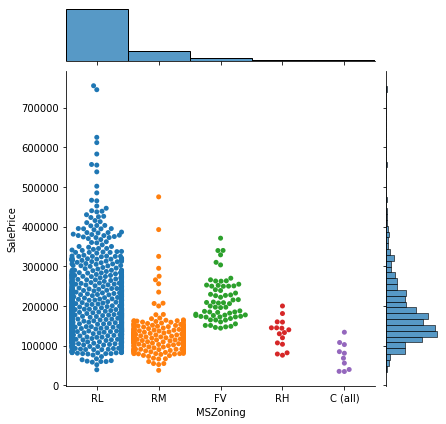

In [147]:
MSZoningD = sData[['MSZoning','SalePrice']]


g = sns.JointGrid(x=sData['MSZoning'], 
                  y=sData['SalePrice'])
ax = g.plot(sns.swarmplot, sns.histplot)

RL > RM > FV > RH > C 순으로 높은 가격이 분포되어 있지만 

전반적으로 RL 데이터양이 많아서 이러한 분포가 나타난 것일 수 있다.

오히려 최적 가격대를 기준으로 본다면 
FV > RH > RL > RM > C 으로 봐야할 수 있다. 

정확한 비례관계가 어렵기 때문에 다른 수치와 함께 파악할 필요가 있어보인다.

## 거주지 유형에 따른 경향성

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 77.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 17.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


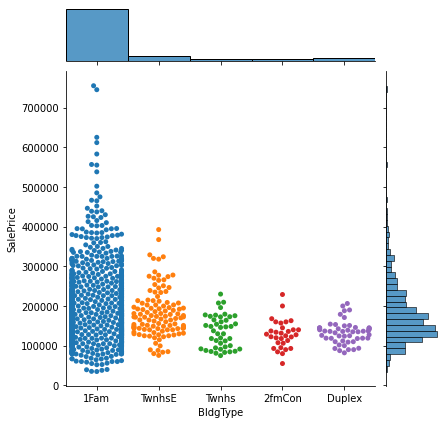

In [148]:
BldgTypeD = sData[['BldgType','SalePrice']]


g = sns.JointGrid(x=sData['BldgType'], 
                  y=sData['SalePrice'])
ax = g.plot(sns.swarmplot, sns.histplot)

In [135]:
"""
sData = data.sort_values(by = ['SalePrice'],ascending=False)
sData = sData.reset_index(drop=True)

sData
upper10p = sData.loc[0:data[c].count() * 0.1]
"""
'''
#val 값 접근 테스트 

print(upper10Maj[(upper10Maj['title']=='Utilities')].index.tolist()[0])
print(upper10Maj.iat[2,1])
'''

2
AllPub
